## I follow Alan's GitHub and rely on 'pyjet' for jet clustering. And I pick $M_{Z^\prime}=1500$ GeV as example.
https://github.com/alan200276/SVJ_Study/blob/master/Jet_Clustering.ipynb  
https://github.com/scikit-hep/pyjet  
https://pypi.org/project/pyjet/  
https://github.com/scikit-hep/pyjet/blob/master/examples/example.py

## Import Packages

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import uproot
import pyjet
import pandas as pd
import sys, os
import importlib
import time
import datetime

%config InlineBackend.figure_format = 'retina'  # increase figure showing resolution

## Import .root File

In [2]:
filepath_3_5 = '/youwei_home/SVJ_py/Tutorial_v2/ROOT/rinv03/test0_2.root'  # 0_2 stands for zeroth generation and Z'=1500 GeV
file_3_5 = uproot.open(filepath_3_5)['Delphes;1']
file_3_5

<TTree b'Delphes' at 0x7f770410d470>

## Define the class to Fill Particle Informations into np.array

In [3]:
class BranchGenParticles:
    def __init__(self, data):
        self.data = data
        self.length = len(data.array('Particle.Status'))
        self.Status = data.array('Particle.Status')
        self.PID = data.array('Particle.PID')
        self.M1 = data.array('Particle.M1')
        self.M2 = data.array('Particle.M2')
        self.D1 = data.array('Particle.D1')
        self.D2 = data.array('Particle.D2')
        self.PT = data.array('Particle.PT')
        self.Eta = data.array('Particle.Eta')
        self.Phi = data.array('Particle.Phi')
        self.Mass = data.array('Particle.Mass')
        self.Labels = ['Status', 'PID', 'M1', 'M2', 'D1', 'D2', 'PT', 'Eta', 'Phi', 'Mass']
        
        
#     To get the GenParticles information array in the i-th event.
    def length_i(self, i):
        return len(self.Status[i])
    def Status_i(self, i):
        return self.Status[i]
    def PID_i(self, i):
        return self.PID[i]
    def M1_i(self, i):
        return self.M1[i]
    def M2_i(self, i):
        return self.M2[i]
    def D1_i(self, i):
        return self.D1[i]
    def D2_i(self, i):
        return self.D2[i]
    def PT_i(self, i):
        return self.PT[i]
    def Eta_i(self, i):
        return self.Eta[i]
    def Phi_i(self, i):
        return self.Phi[i]
    def Mass_i(self, i):
        return self.Mass[i]
    
    
    
class BranchJet:
    def __init__(self, data):
        self.data = data
        self.length = len(data.array('Jet.PT'))
        self.PT = data.array('Jet.PT')
        self.Eta = data.array('Jet.Eta')
        self.Phi = data.array('Jet.Phi')
        self.Mass = data.array('Jet.Mass')
        
    def length_i(self, i):
        return len(self.PT[i])
    def PT_i(self, i):
        return self.PT[i]
    def Eta_i(self, i):
        return self.Eta[i]
    def Phi_i(self, i):
        return self.Phi[i]
    def Mass_i(self, i):
        return self.Mass[i]
    
    
    
class Event_Weight:
    def __init__(self, data):
        self.data = data
        self.length = len(data.array('Event.Weight'))
        self.Event_Weight = np.array(data.array('Event.Weight'))
        
    def Event_Weight_i(self, i):
        return self.Event_Weight[i]

#### Note: Problems:
1. I want to invariant mass and transverse mass functions to be written in class.
2. Why np.array(data.array('Event.Weight'))

## Define Functions

### 1. Invariant Mass and Transverse Mass

In [4]:
def M(pt1, eta1, phi1, m1, pt2, eta2, phi2, m2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    return np.sqrt((e1+e2)**2 - (px1+px2)**2 - (py1+py2)**2 - (pz1+pz2)**2)



def MT(pt1, eta1, phi1, m1, pt2, eta2, phi2, m2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    ET1, ET2 = np.sqrt(m1**2 + pt1**2), np.sqrt(m2**2 + pt2**2)
    return np.sqrt((ET1+ET2)**2 - (px1+px2)**2 - (py1+py2)**2)

### 2. Finding Dark Quarks

In [5]:
def Find_xdxdbar(GP):
#     GP = GenParticles
    m_xdxdbar = []
    for i in range(GP.length):
        acc = 0
        for j in range(GP.length_i(i)):
            PID = GP.PID_i(i)[j]
            M1 = GP.M1_i(i)[j]
            M2 = GP.M2_i(i)[j]
            D1 = GP.D1_i(i)[j]
            D2 = GP.D2_i(i)[j]
            Status = GP.Status_i(i)[j]
            
            if PID == 5000001:
                if abs(GP.PID_i(i)[D1]) == abs(GP.PID_i(i)[D2]) == 4900101 and GP.Status_i(i)[D1] == GP.Status_i(i)[D2] == 23:
                    tmp_pt1 = GP.PT_i(i)[D1]
                    tmp_eta1 = GP.Eta_i(i)[D1]
                    tmp_phi1 = GP.Phi_i(i)[D1]
                    tmp_m1 = GP.Mass_i(i)[D1]
                    
                    tmp_pt2 = GP.PT_i(i)[D2]
                    tmp_eta2 = GP.Eta_i(i)[D2]
                    tmp_phi2 = GP.Phi_i(i)[D2]
                    tmp_m2 = GP.Mass_i(i)[D2]
                    break
            elif PID == 4900101 and Status == 23:
                tmp_pt1 = GP.PT_i(i)[j]
                tmp_eta1 = GP.Eta_i(i)[j]
                tmp_phi1 = GP.Phi_i(i)[j]
                tmp_m1 = GP.Mass_i(i)[j]
                acc += 1
                if acc == 2:
                    break
            elif PID == -4900101 and Status == 23:
                tmp_pt2 = GP.PT_i(i)[j]
                tmp_eta2 = GP.Eta_i(i)[j]
                tmp_phi2 = GP.Phi_i(i)[j]
                tmp_m2 = GP.Mass_i(i)[j]
                acc += 1
                if acc == 2:
                    break
                    
        m_xdxdbar.append(M(tmp_pt1, tmp_eta1, tmp_phi1, tmp_m1, tmp_pt2, tmp_eta2, tmp_phi2, tmp_m2))
            
    return np.array(m_xdxdbar)

### 3. Checking $r_\text{inv}$

In [6]:
def Check_rinv_bRatio(GP, darkhadron=4900111, dm=51):
    invis_count, vis_count = 0, 0
    for i in range(GP.length):
        for j in range(GP.length_i(i)):
            PID = GP.PID_i(i)[j]
            M1 = GP.M1_i(i)[j]
            M2 = GP.M2_i(i)[j]
            D1 = GP.D1_i(i)[j]
            D2 = GP.D2_i(i)[j]
            Status = GP.Status_i(i)[j]
            
            if abs(PID) == darkhadron and abs(GP.PID_i(i)[D1]) != darkhadron and abs(GP.PID_i(i)[D2]) != darkhadron:
                if abs(GP.PID_i(i)[D1]) < 6 and abs(GP.PID_i(i)[D2]) < 6:  # and becomes to or??
                    vis_count += 1
                elif abs(GP.PID_i(i)[D1]) == dm and abs(GP.PID_i(i)[D2]) == dm:
                    invis_count += 1
            
    print('There are {} events.'.format(GP.length))
    print('There are {} Dark Mesons decay into invisible particle.'.format(invis_count))
    print('There are {} Dark Mesons decay into visible particle.'.format(vis_count))
    print('r_inv = {:^6.4f}'.format(invis_count/(invis_count+vis_count)))
    
    return invis_count/(invis_count+vis_count), invis_count, vis_count

### 4. Preselection

In [7]:
def Preselection(Jet):
    twojet_invariantmass = []
    survived_list = []
    for i in range(Jet.length):
        if Jet.length_i(i) < 2:
            continue
        elif Jet.PT_i(i)[0] < 440 or Jet.PT_i(i)[1] < 60:
            continue
        elif np.abs(Jet.Eta_i(i)[0]-Jet.Eta_i(i)[1]) > 1.2:
            continue
            
        twojet_invariantmass.append(M(Jet.PT_i(i)[0], Jet.Eta_i(i)[0], Jet.Phi_i(i)[0], Jet.Mass_i(i)[0],
                                      Jet.PT_i(i)[1], Jet.Eta_i(i)[1], Jet.Phi_i(i)[1], Jet.Mass_i(i)[1]))
        survived_list.append(i)
        
    print('There are {} events.'.format(len(twojet_invariantmass)))
    return np.array(twojet_invariantmass), np.array(survived_list)

### 5. Select stable final state particles

In [8]:
def StableFinalStateParticles(GP):
    event_SFSP = []
    for i in range(GP.length):
        event_SFSP_tmp = []
        for j in range(GP.length_i(i)):
            if GP.Status_i(i)[j] == 1:  # Stable Final State Particles
                event_SFSP_tmp.append([GP.PT_i(i)[j], GP.Eta_i(i)[j], GP.Phi_i(i)[j], GP.Mass_i(i)[j], GP.PID_i(i)[j]])
                
        event_SFSP.append(np.array(event_SFSP_tmp))
        
    return event_SFSP

#### Note: The status of stable final state particles in truth record is 1.
event_SFSP = [[event0], [event1], [event2],...]  
event_SFSP = [[(pT00, eta00, phi00, mass00, PID00), (pT01, eta01, phi01, mass01, PID01),...], [(pT10, eta10, phi10, mass10, PID10), (),...], [],...]

## Load Event via class

In [9]:
GP_3_5, Jet_3_5, EW_3_5 = BranchGenParticles(file_3_5), BranchJet(file_3_5), Event_Weight(file_3_5)

## Print the Truth Record in First Event for Status=1

In [10]:
GP = GP_3_5
index = 0  # which event you want to print out

print('There are {} informations in this event.'.format(GP.length_i(index)))
print('{:^81}'.format('GenParticles Information'))
print('{:^5}{:^7}{:^8}{:^7}{:^7}{:^7}{:^7}{:^8}{:^8}{:^10}{:^8}'.format('#', 'Status', 'PID', 'M1', 'M2', 'D1', 'D2', 'PT', 'Eta', 'Phi', 'Mass'))
print('-'*81)

for j in range(GP.length_i(index)):
    if GP.Status_i(index)[j] == 1:  # Stable Final State Particles
        print('{:^5}{:^7d}{:^8d}{:^7d}{:^7d}{:^7d}{:^7d}{:^8.3f}{:^8.3f}{:^10.3f}{:^8.3f}'.format(j, GP.Status_i(index)[j], GP.PID_i(index)[j], GP.M1_i(index)[j],
                                                                           GP.M2_i(index)[j], GP.D1_i(index)[j], GP.D2_i(index)[j],
                                                                           GP.PT_i(index)[j], GP.Eta_i(index)[j], GP.Phi_i(index)[j], GP.Mass_i(index)[j]))

There are 1988 informations in this event.
                            GenParticles Information                             
  #  Status   PID     M1     M2     D1     D2      PT     Eta      Phi      Mass  
---------------------------------------------------------------------------------
 531    1      22     427    427    -1     -1    0.957   0.053    0.521    0.000  
 814    1     2212    812    813    -1     -1    1.129   -7.518   -1.319   0.938  
 815    1     -211    812    813    -1     -1    0.717   -8.754   -3.056   0.140  
 820    1     -211    816    819    -1     -1    2.463   0.003    2.040    0.140  
 827    1     -321    823    826    -1     -1    0.198   -1.844   -2.262   0.494  
 828    1     211     823    826    -1     -1    0.279   -1.910   -1.807   0.140  
 832    1     211     823    826    -1     -1    0.789   -0.961   -1.791   0.140  
 839    1     -211    833    837    -1     -1    0.212   1.412    0.331    0.140  
 840    1     211     833    837    -1     -1 

## Select Stable Final State Particles

In [11]:
print(time.strftime('%m/%d/%Y %a, %H:%M:%S %Z', time.localtime()))
start = datetime.datetime.now()

event_SFSP = StableFinalStateParticles(GP_3_5)
print('There are {} events in this event list.'.format(len(event_SFSP)))

end = datetime.datetime.now()
print('Time =', end - start)

12/24/2020 Thu, 04:37:14 UTC
There are 14418 events in this event list.
Time = 0:08:46.485602


### Structure of event_SFSP

In [12]:
event_SFSP

[array([[ 9.56843555e-01,  5.32473847e-02,  5.21393239e-01,
          0.00000000e+00,  2.20000000e+01],
        [ 1.12938380e+00, -7.51762915e+00, -1.31930101e+00,
          9.38269973e-01,  2.21200000e+03],
        [ 7.17465699e-01, -8.75418091e+00, -3.05637455e+00,
          1.39569998e-01, -2.11000000e+02],
        ...,
        [ 5.24743497e-01, -2.39432240e+00,  9.36662555e-01,
          1.39569998e-01, -2.11000000e+02],
        [ 2.72607833e-01, -1.91578591e+00, -7.58749843e-01,
          1.39569998e-01,  2.11000000e+02],
        [ 6.12200558e-01, -2.51267099e+00, -2.42362905e+00,
          1.39569998e-01, -2.11000000e+02]]),
 array([[ 5.16164184e-01,  7.53863144e+00, -7.06369758e-01,
          1.39569998e-01,  2.11000000e+02],
        [ 3.13164055e-01, -9.09868908e+00, -1.88927567e+00,
          9.38269973e-01,  2.21200000e+03],
        [ 1.00564587e+00,  6.97250485e-01,  2.76627040e+00,
          1.39569998e-01, -2.11000000e+02],
        ...,
        [ 1.69122887e+00,  7.0159900

In [13]:
event_SFSP[0][1][0]

1.1293838024139404

In [14]:
print('There are {} events.'.format(len(event_SFSP)))
print('-'*51)
print('There are {} particles with status=1 in 1st event.'.format(len(event_SFSP[0])))
print('There are {} particles with status=1 in 2nd event.'.format(len(event_SFSP[1])))
print('There are {} particles with status=1 in 3rd event.'.format(len(event_SFSP[2])))
print('-'*51)
print('There are {} informations in each particles.'.format(len(event_SFSP[0][0])))
print('There are {} informations in each particles.'.format(len(event_SFSP[0][1])))
print('There are {} informations in each particles.'.format(len(event_SFSP[1][0])))
print('There are {} informations in each particles.'.format(len(event_SFSP[1][1])))
print('There are {} informations in each particles.'.format(len(event_SFSP[2][0])))
print('There are {} informations in each particles.'.format(len(event_SFSP[2][1])))

There are 14418 events.
---------------------------------------------------
There are 618 particles with status=1 in 1st event.
There are 555 particles with status=1 in 2nd event.
There are 595 particles with status=1 in 3rd event.
---------------------------------------------------
There are 5 informations in each particles.
There are 5 informations in each particles.
There are 5 informations in each particles.
There are 5 informations in each particles.
There are 5 informations in each particles.
There are 5 informations in each particles.


In [15]:
print(event_SFSP[0][0])
print(event_SFSP[0][1])
print(event_SFSP[0][2])
event_SFSP[0]

[ 0.95684355  0.05324738  0.52139324  0.         22.        ]
[ 1.12938380e+00 -7.51762915e+00 -1.31930101e+00  9.38269973e-01
  2.21200000e+03]
[ 7.17465699e-01 -8.75418091e+00 -3.05637455e+00  1.39569998e-01
 -2.11000000e+02]


array([[ 9.56843555e-01,  5.32473847e-02,  5.21393239e-01,
         0.00000000e+00,  2.20000000e+01],
       [ 1.12938380e+00, -7.51762915e+00, -1.31930101e+00,
         9.38269973e-01,  2.21200000e+03],
       [ 7.17465699e-01, -8.75418091e+00, -3.05637455e+00,
         1.39569998e-01, -2.11000000e+02],
       ...,
       [ 5.24743497e-01, -2.39432240e+00,  9.36662555e-01,
         1.39569998e-01, -2.11000000e+02],
       [ 2.72607833e-01, -1.91578591e+00, -7.58749843e-01,
         1.39569998e-01,  2.11000000e+02],
       [ 6.12200558e-01, -2.51267099e+00, -2.42362905e+00,
         1.39569998e-01, -2.11000000e+02]])

In [16]:
GP = GP_3_5
index = 0  # which event you want to print out

print('There are {} informations in this event.'.format(GP.length_i(index)))
print('Print out first six informations of particle')
print('{:^81}'.format('GenParticles Information'))
print('{:^5}{:^7}{:^8}{:^7}{:^7}{:^7}{:^7}{:^8}{:^8}{:^10}{:^8}'.format('#', 'Status', 'PID', 'M1', 'M2', 'D1', 'D2', 'PT', 'Eta', 'Phi', 'Mass'))
print('-'*81)

for j in range(830):
    if GP.Status_i(index)[j] == 1:  # Stable Final State Particles
        print('{:^5}{:^7d}{:^8d}{:^7d}{:^7d}{:^7d}{:^7d}{:^8.3f}{:^8.3f}{:^10.3f}{:^8.3f}'.format(j, GP.Status_i(index)[j], GP.PID_i(index)[j], GP.M1_i(index)[j],
                                                                           GP.M2_i(index)[j], GP.D1_i(index)[j], GP.D2_i(index)[j],
                                                                           GP.PT_i(index)[j], GP.Eta_i(index)[j], GP.Phi_i(index)[j], GP.Mass_i(index)[j]))

There are 1988 informations in this event.
Print out first six informations of particle
                            GenParticles Information                             
  #  Status   PID     M1     M2     D1     D2      PT     Eta      Phi      Mass  
---------------------------------------------------------------------------------
 531    1      22     427    427    -1     -1    0.957   0.053    0.521    0.000  
 814    1     2212    812    813    -1     -1    1.129   -7.518   -1.319   0.938  
 815    1     -211    812    813    -1     -1    0.717   -8.754   -3.056   0.140  
 820    1     -211    816    819    -1     -1    2.463   0.003    2.040    0.140  
 827    1     -321    823    826    -1     -1    0.198   -1.844   -2.262   0.494  
 828    1     211     823    826    -1     -1    0.279   -1.910   -1.807   0.140  


In [17]:
event_SFSP0_trans = event_SFSP[0].transpose()
event_SFSP1_trans = event_SFSP[1].transpose()
event_SFSP2_trans = event_SFSP[2].transpose()
event_SFSP0_trans

array([[ 9.56843555e-01,  1.12938380e+00,  7.17465699e-01, ...,
         5.24743497e-01,  2.72607833e-01,  6.12200558e-01],
       [ 5.32473847e-02, -7.51762915e+00, -8.75418091e+00, ...,
        -2.39432240e+00, -1.91578591e+00, -2.51267099e+00],
       [ 5.21393239e-01, -1.31930101e+00, -3.05637455e+00, ...,
         9.36662555e-01, -7.58749843e-01, -2.42362905e+00],
       [ 0.00000000e+00,  9.38269973e-01,  1.39569998e-01, ...,
         1.39569998e-01,  1.39569998e-01,  1.39569998e-01],
       [ 2.20000000e+01,  2.21200000e+03, -2.11000000e+02, ...,
        -2.11000000e+02,  2.11000000e+02, -2.11000000e+02]])

In [18]:
print(event_SFSP[0][5][1], event_SFSP[2][12][2])
print(event_SFSP0_trans[1][5], event_SFSP2_trans[2][12])

-1.9099113941192627 -0.2679380476474762
-1.9099113941192627 -0.2679380476474762


In [19]:
print(event_SFSP[0].dtype, event_SFSP[1].dtype, event_SFSP[2].dtype)
print(event_SFSP0_trans.dtype, event_SFSP1_trans.dtype, event_SFSP2_trans.dtype)
print('-'*26)
print(event_SFSP[0].shape, event_SFSP[1].shape, event_SFSP[2].shape)
print(event_SFSP0_trans.shape, event_SFSP1_trans.shape, event_SFSP2_trans.shape)

float64 float64 float64
float64 float64 float64
--------------------------
(618, 5) (555, 5) (595, 5)
(5, 618) (5, 555) (5, 595)


In [22]:
event_SFSP.dtype

AttributeError: 'list' object has no attribute 'dtype'

In [26]:
event_SFSP[0].shape()

TypeError: 'tuple' object is not callable

## Let's Do Jet Clustering!!

#### Note: We use 'np.core.records.fromarrays' to assign the name of kinematic variables and PID.
In pyjet, the data type are only  
np.dtype([('pT', 'f8'), ('eta', 'f8'), ('phi', 'f8'), ('mass', 'f8')])  
or (cluster(..., ep=True))  
np.dtype([('E', 'f8'), ('px', 'f8'), ('py', 'f8'), ('pz', 'f8')])  

In this example, we use (pT, eta, phi, mass).  
After assigning the name for our each event list, the 'pyjet.cluster' and '.inclusive_jets' will help us do jet clustering.  
sequence_cluster = pyjet.cluster(to_cluster, R=0.6, p=-1)  
jets_cluster = sequence_cluster.inclusive_jets(pT_min)  
where  
R = the cone size of the jet  
p = the jet clustering algorithm: -1 = anti-kt, 0 = Cambridge-Aachen(C/A), 1 = kt  
pTmin = the minimum pT of jet

In [20]:
test_event0 = np.core.records.fromarrays(event_SFSP[0].transpose(),
                                   names = 'pT, eta, phi, mass, PID',
                                   formats = 'f8, f8, f8, f8, f8')
sequence = pyjet.cluster(test_event0, R=0.6, p=-1)
jets = sequence.inclusive_jets()

print(test_event0.dtype)
print(test_event0[0].dtype)
print(test_event0.pT)
test_event0[0]

(numpy.record, [('pT', '<f8'), ('eta', '<f8'), ('phi', '<f8'), ('mass', '<f8'), ('PID', '<f8')])
(numpy.record, [('pT', '<f8'), ('eta', '<f8'), ('phi', '<f8'), ('mass', '<f8'), ('PID', '<f8')])
[9.56843555e-01 1.12938380e+00 7.17465699e-01 2.46339846e+00
 1.98341250e-01 2.78623968e-01 7.89360404e-01 2.12011874e-01
 1.87001050e+00 5.12936950e-01 2.17649236e-01 8.55160356e-01
 1.50352049e+00 7.28044212e-01 1.10436344e+00 2.69535422e-01
 5.63165367e-01 3.70382905e-01 1.03690803e+00 4.40908939e-01
 2.04701185e-01 2.43850410e-01 5.62990546e-01 5.10650396e-01
 1.44900233e-01 2.82426197e-02 3.29534411e-01 1.87372160e+00
 3.26714545e-01 1.10887480e+00 9.93512988e-01 4.86187667e-01
 6.73988342e-01 4.83717173e-01 5.38462102e-01 4.59781736e-01
 1.72060394e+00 7.14739978e-01 5.18159926e-01 8.76852214e-01
 4.55316812e-01 5.64885199e-01 2.34068370e+00 6.56665146e-01
 1.70890200e+00 6.98019207e-01 1.22024953e+00 2.72800207e+00
 1.77165520e+00 2.56660533e+00 6.88309908e-01 1.05348349e+00
 9.92166623e-

(0.95684355, 0.05324738, 0.52139324, 0., 22.)

In [21]:
print(test_event0.pT[0], test_event0.eta[0], test_event0.phi[0], test_event0.mass[0], test_event0.PID[0])
event_SFSP[0][0]

0.9568435549736023 0.05324738472700119 0.5213932394981384 0.0 22.0


array([ 0.95684355,  0.05324738,  0.52139324,  0.        , 22.        ])

In [22]:
jets

[PseudoJet(pt=283.575, eta=0.598, phi=1.120, mass=93.611),
 PseudoJet(pt=251.825, eta=-2.232, phi=-2.296, mass=66.594),
 PseudoJet(pt=51.531, eta=-1.530, phi=-1.594, mass=29.375),
 PseudoJet(pt=46.576, eta=-1.399, phi=-2.357, mass=43.720),
 PseudoJet(pt=38.199, eta=0.096, phi=0.210, mass=23.750),
 PseudoJet(pt=32.108, eta=2.630, phi=0.527, mass=10.311),
 PseudoJet(pt=17.839, eta=-1.197, phi=-0.717, mass=6.571),
 PseudoJet(pt=17.502, eta=-2.979, phi=0.281, mass=4.604),
 PseudoJet(pt=16.051, eta=-2.354, phi=-3.099, mass=5.105),
 PseudoJet(pt=12.755, eta=-0.450, phi=-2.743, mass=5.926),
 PseudoJet(pt=12.587, eta=-1.911, phi=0.212, mass=5.660),
 PseudoJet(pt=8.311, eta=0.263, phi=2.753, mass=5.341),
 PseudoJet(pt=6.556, eta=-2.437, phi=-1.580, mass=2.287),
 PseudoJet(pt=6.535, eta=1.429, phi=1.162, mass=1.559),
 PseudoJet(pt=6.236, eta=-0.564, phi=-1.975, mass=1.444),
 PseudoJet(pt=5.408, eta=5.692, phi=0.661, mass=1.642),
 PseudoJet(pt=5.170, eta=-2.061, phi=-0.580, mass=1.371),
 PseudoJe

In [23]:
print(len(jets))
print(jets[0], len(jets[0]))
print(jets[1], len(jets[1]))

102
PseudoJet(pt=283.575, eta=0.598, phi=1.120, mass=93.611) 38
PseudoJet(pt=251.825, eta=-2.232, phi=-2.296, mass=66.594) 79


#### Note: Above is just testing example.

In [24]:
event_jets = []
for i in range(len(event_SFSP)):
    event_i = np.core.records.fromarrays(event_SFSP[i].transpose(),
                                         names='pT, eta, phi, mass, PID',
                                         formats='f8, f8, f8, f8, f8')
    pTmin = 200
    sequence_i = pyjet.cluster(event_i, R=0.6, p=-1)
    jets_i = sequence_i.inclusive_jets(pTmin)
    event_jets.append(jets_i)

In [25]:
event_jets

[[PseudoJet(pt=283.575, eta=0.598, phi=1.120, mass=93.611),
  PseudoJet(pt=251.825, eta=-2.232, phi=-2.296, mass=66.594)],
 [PseudoJet(pt=776.472, eta=0.133, phi=2.686, mass=109.082),
  PseudoJet(pt=652.142, eta=0.061, phi=-0.195, mass=104.328)],
 [PseudoJet(pt=556.743, eta=0.344, phi=0.351, mass=161.764),
  PseudoJet(pt=554.252, eta=1.890, phi=-2.807, mass=112.083)],
 [PseudoJet(pt=345.419, eta=-0.141, phi=-0.723, mass=70.513),
  PseudoJet(pt=212.718, eta=0.052, phi=2.908, mass=56.548)],
 [PseudoJet(pt=245.306, eta=1.791, phi=-1.583, mass=55.722),
  PseudoJet(pt=222.475, eta=-1.510, phi=1.390, mass=79.595)],
 [PseudoJet(pt=357.228, eta=0.733, phi=1.463, mass=73.912)],
 [],
 [PseudoJet(pt=419.636, eta=-1.445, phi=-1.385, mass=108.053),
  PseudoJet(pt=383.382, eta=0.469, phi=1.884, mass=100.932)],
 [],
 [PseudoJet(pt=290.542, eta=-2.694, phi=1.097, mass=90.942),
  PseudoJet(pt=276.058, eta=0.314, phi=-2.036, mass=35.007)],
 [PseudoJet(pt=714.042, eta=-0.081, phi=0.865, mass=119.312),
  

In [26]:
# print(event_jets[0].dtype)
# print(event_jets[0][0].dtype)
event_jets[0]

[PseudoJet(pt=283.575, eta=0.598, phi=1.120, mass=93.611),
 PseudoJet(pt=251.825, eta=-2.232, phi=-2.296, mass=66.594)]

In [27]:
print('There are {} events.'.format(len(event_jets)))
print('-'*59)
print('There are {} PseudoJets with pTmin=200 in 1st event.'.format(len(event_jets[0])))
print('There are {} PseudoJets with pTmin=200 in 2nd event.'.format(len(event_jets[1])))
print('-'*59)
print('There are {} constituents in 1 PseudoJet of 1st event.'.format(len(event_jets[0][0])),'\n',event_jets[0][0])
print('There are {} constituents in 2 PseudoJet of 1st event.'.format(len(event_jets[0][1])),'\n',event_jets[0][1])

There are 14418 events.
-----------------------------------------------------------
There are 2 PseudoJets with pTmin=200 in 1st event.
There are 2 PseudoJets with pTmin=200 in 2nd event.
-----------------------------------------------------------
There are 38 constituents in 1 PseudoJet of 1st event. 
 PseudoJet(pt=283.575, eta=0.598, phi=1.120, mass=93.611)
There are 79 constituents in 2 PseudoJet of 1st event. 
 PseudoJet(pt=251.825, eta=-2.232, phi=-2.296, mass=66.594)


In [28]:
event_jets[0][1][2]

TypeError: 'pyjet._libpyjet.PseudoJet' object does not support indexing

In [29]:
dir(event_jets[0][0])

['__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'area',
 'child',
 'constituents',
 'constituents_array',
 'e',
 'et',
 'eta',
 'mass',
 'parents',
 'phi',
 'pt',
 'px',
 'py',
 'pz',
 'userinfo']

In [30]:
print(event_jets[0][0])
print(getattr(event_jets[0][0],'pt'), getattr(event_jets[0][0],'eta'), getattr(event_jets[0][0],'phi'), getattr(event_jets[0][0],'mass'))
print(getattr(event_jets[0][0],'e'), getattr(event_jets[0][0],'px'), getattr(event_jets[0][0],'py'), getattr(event_jets[0][0],'pz'))

PseudoJet(pt=283.575, eta=0.598, phi=1.120, mass=93.611)
283.57485310481917 0.5982626553796551 1.1204562060625547 93.61127218862237
348.6568998317064 123.43212814607764 255.30218772025833 179.95517832522762


In [31]:
pt = getattr(event_jets[0][0],'pt')
eta = getattr(event_jets[0][0],'eta')
phi = getattr(event_jets[0][0],'phi')
m = getattr(event_jets[0][0],'mass')

mt = m**2 + pt**2
px = pt*np.cos(phi)
py = pt*np.sin(phi)
pz_mt = mt*np.sinh(eta)
pz_pt = pt*np.sinh(eta)
E_mt = np.sqrt(m**2 + pt**2 + pz_mt**2)
E_pt = np.sqrt(m**2 + pt**2 + pz_pt**2)
print(E_pt, px, py, pz_pt)
print(E_pt-getattr(event_jets[0][0],'e'), px-getattr(event_jets[0][0],'px'), py-getattr(event_jets[0][0],'py'), pz_pt-getattr(event_jets[0][0],'pz'))

348.6568998317065 123.43212814607764 255.30218772025836 179.95517832522768
5.684341886080802e-14 0.0 2.842170943040401e-14 5.684341886080802e-14


## Print Jets in the ith(first) Event

#### Note: Because I take pTmin=200, cut off many jets.

In [32]:
# Printing a few things here as a demonstration of the basic functionality
ith = 0

print('Information of {}th Event'.format(ith+1))
print('{0: <5} {1: >10} {2: >10} {3: >10} {4: >10} {5: >10}'.format('jet#', 'pT', 'eta', 'phi', 'mass', '#constit.'))
for i, jet in enumerate(event_jets[ith]):
    print('{0: <5} {1: 10.3f} {2: 10.3f} {3: 10.3f} {4: 10.3f} {5: 10}'.format(i+1, jet.pt, jet.eta, jet.phi, jet.mass, len(jet)))
    
print('\nThe 2th jet has {} particles in 2nd PseudoJet.'.format(len(event_jets[ith][1])))
print('\nThe 2th jet has the following constituents:')
for constit in event_jets[ith][1]:
    print(constit)
print('\nGet the constituents as an array (pT, eta, phi, mass):')
print(event_jets[ith][1].constituents_array())
print('\nor (E, px, py, pz):')
print(event_jets[ith][1].constituents_array(ep=True))

Information of 1th Event
jet#          pT        eta        phi       mass  #constit.
1        283.575      0.598      1.120     93.611         38
2        251.825     -2.232     -2.296     66.594         79

The 2th jet has 79 particles in 2nd PseudoJet.

The 2th jet has the following constituents:
PseudoJet(pt=0.040, eta=-1.885, phi=-1.803, mass=-0.000)
PseudoJet(pt=0.697, eta=-2.255, phi=-2.674, mass=0.938)
PseudoJet(pt=0.681, eta=-1.812, phi=-2.717, mass=0.000)
PseudoJet(pt=0.999, eta=-1.651, phi=-2.421, mass=0.140)
PseudoJet(pt=0.483, eta=-2.047, phi=-1.754, mass=0.140)
PseudoJet(pt=1.151, eta=-2.604, phi=-2.674, mass=0.000)
PseudoJet(pt=4.069, eta=-1.676, phi=-2.273, mass=0.498)
PseudoJet(pt=0.340, eta=-2.071, phi=-2.784, mass=0.140)
PseudoJet(pt=6.414, eta=-2.067, phi=-2.784, mass=0.106)
PseudoJet(pt=0.214, eta=-2.380, phi=-1.784, mass=0.000)
PseudoJet(pt=0.187, eta=-1.900, phi=-1.879, mass=0.000)
PseudoJet(pt=0.508, eta=-1.711, phi=-2.282, mass=-0.000)
PseudoJet(pt=0.295, eta=-

In [33]:
ith = 0

for i, jets in enumerate(event_jets[ith]):
    print('{}'.format('No.'+str(i+1)+" Jet's Information"))
    print(jets)
    print('-'*75)
    print('{:^19}{:^56}'.format("Constituent's PID", "Constituent's Four Momentum"))
    print('-'*75)
    for constit in jets:
        print('{:^19}{}'.format(int(constit.PID), constit))
    print('='*75)

No.1 Jet's Information
PseudoJet(pt=283.575, eta=0.598, phi=1.120, mass=93.611)
---------------------------------------------------------------------------
 Constituent's PID               Constituent's Four Momentum               
---------------------------------------------------------------------------
        -53        PseudoJet(pt=9.042, eta=0.348, phi=0.754, mass=9.990)
        53         PseudoJet(pt=10.101, eta=0.342, phi=0.801, mass=9.990)
        22         PseudoJet(pt=0.200, eta=0.823, phi=0.901, mass=0.000)
       -211        PseudoJet(pt=0.818, eta=0.707, phi=0.852, mass=0.140)
       -321        PseudoJet(pt=0.603, eta=1.060, phi=1.067, mass=0.494)
        22         PseudoJet(pt=1.692, eta=0.711, phi=1.398, mass=0.000)
        211        PseudoJet(pt=1.878, eta=0.543, phi=1.401, mass=0.140)
       -211        PseudoJet(pt=2.134, eta=0.367, phi=1.040, mass=0.140)
        22         PseudoJet(pt=0.965, eta=0.419, phi=0.969, mass=0.000)
        22         PseudoJet(pt=0.

## Find the Xd(4900101) and Xd~(-4900101) in the Truth Record Table for Invariant Mass

In [34]:
print(time.strftime('%m/%d/%Y %a, %H:%M:%S %Z', time.localtime()))
start = datetime.datetime.now()

m_xdxdbar = Find_xdxdbar(GP_3_5)

end = datetime.datetime.now()
print('Time =', end - start)

12/24/2020 Thu, 04:50:25 UTC
Time = 0:04:24.510471


## Calculate di-jet Invariant Mass from Detector Simulation

In [35]:
dijet_mass, survived_list = Preselection(Jet_3_5)

There are 5093 events.


In [36]:
print(dijet_mass.shape)
dijet_mass

(5093,)


array([1145.45285631, 1013.82441537, 1014.180906  , ..., 1153.58328875,
       1042.62257815,  822.71368651])

In [37]:
print(survived_list.shape)
survived_list

(5093,)


array([    1,    10,    14, ..., 14403, 14406, 14416])

#### <font color=red> Note: I don't understand this yet. </font>

## Calculate the Number of Event for Event Weight

#### Note: Luminosity $\mathcal{L} = 37\ \mathrm{fb}^{-1}$

In [38]:
weight_3_5 = EW_3_5.Event_Weight/20000

## di-jet Events' Selection from Truth Record

#### Note: We want to compare the invariant mass distribution between two reconstructed jets and two dark quarks.
We need to select the events with # of jet $\geq$ 2.

In [39]:
M_JJ = []
event_sele = []

for i in range(len(event_jets)):
    if len(event_jets[i]) >= 2:  # at least two jets in this event.
        jet_1 = event_jets[i][0]  # leading jet's information
        jet_2 = event_jets[i][1]  # subleading jet's information
        
        M_JJ.append(M(jet_1.pt, jet_1.eta, jet_1.phi, jet_1.mass, jet_2.pt, jet_2.eta, jet_2.phi, jet_2.mass))
        event_sele.append(i)
        
print('There are {} events passed this di-jet selection.'.format(len(M_JJ)))

There are 12523 events passed this di-jet selection.


In [41]:
print(event_sele)

[0, 1, 2, 3, 4, 7, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 151, 153, 154, 155, 156, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 190, 191, 192, 194, 195, 196, 197, 198, 199, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 222, 223, 225, 227, 229, 230, 231, 232, 235, 236, 238, 239, 240, 241, 242, 244, 245, 246, 247, 248, 249, 250, 251, 253, 254,

## Plot

### Example 1: Plot in differential number of event

#### <font color=red> Notice: $M_{Z^\prime}=1500$ GeV </font>

Total events = 14418


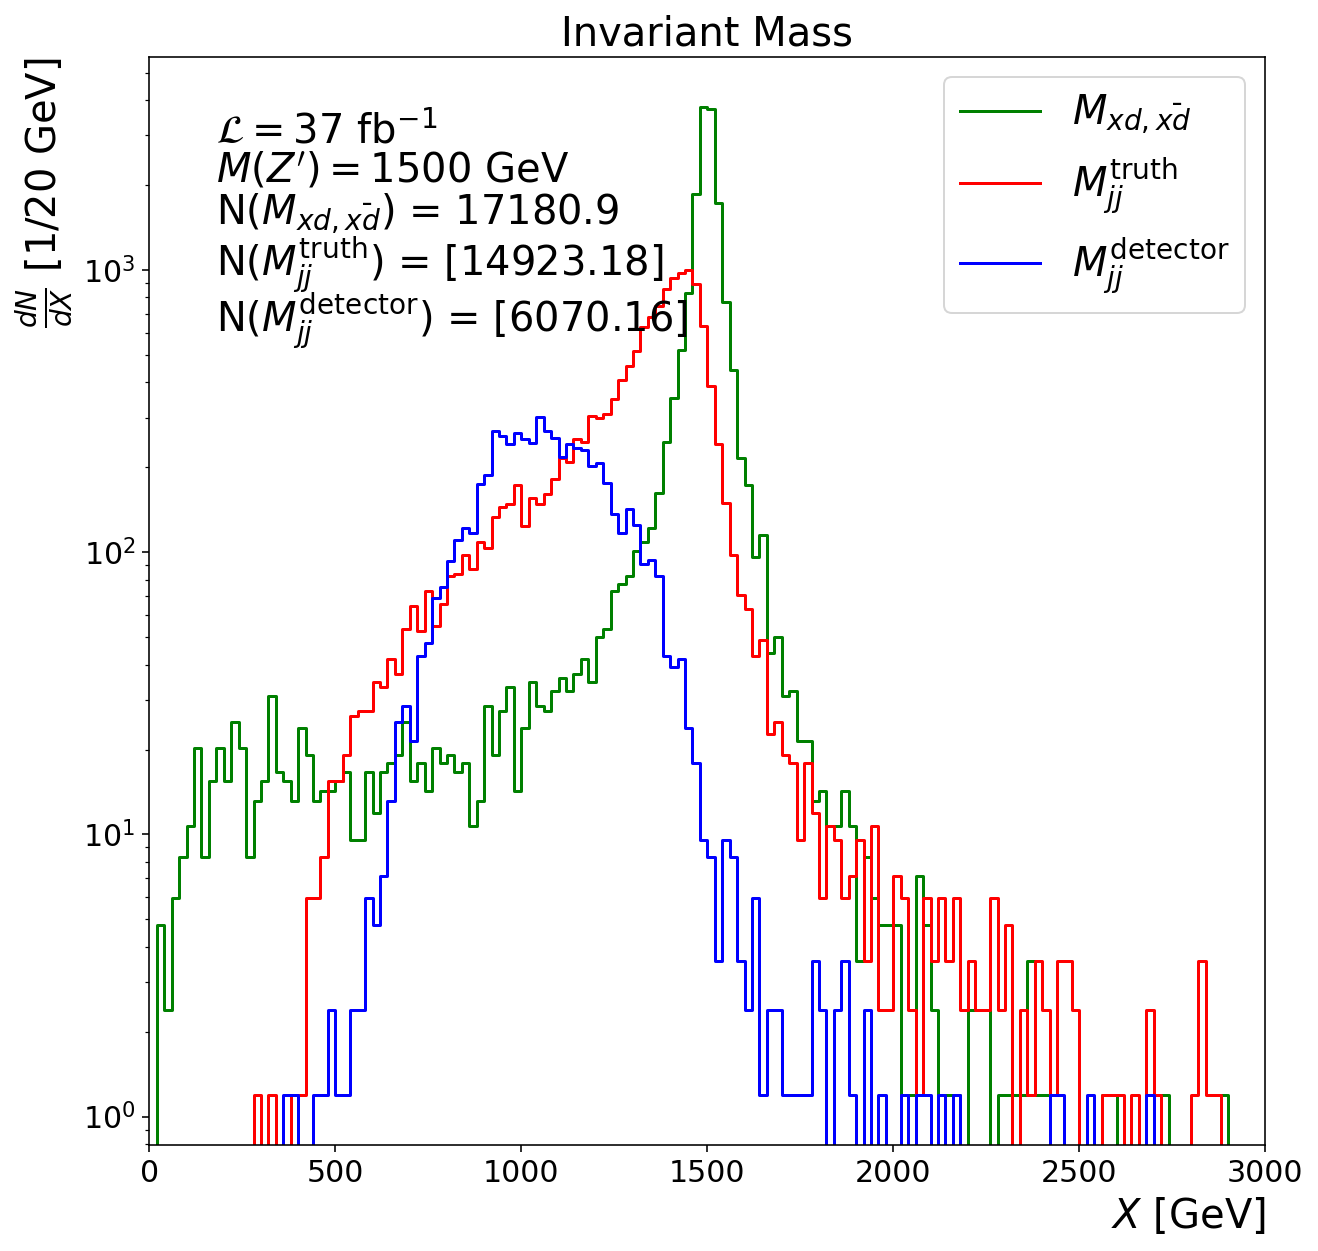

In [44]:
plt.figure(figsize=(10,10))  # plot size
print('Total events = {}'.format(len(m_xdxdbar)))

bin_size = np.linspace(0,5000,251)
hist, bins = np.histogram(m_xdxdbar, bins=bin_size, weights=weight_3_5*37*1000)
plt.step(bins[:-1], hist, where='post', color='green', label='$M_{xd,\\bar{xd}}$')
# plt.step(bins[:-1], hist.astype(np.float32), where='post', color='green', label='$M_{xd,\\bar{xd}}$')

hist_M_JJ, bins_M_JJ = np.histogram(M_JJ, bins=bin_size, weights=weight_3_5[event_sele]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ, where='post', color='red', label='$M^\mathrm{truth}_{jj}$')

hist_M_JJ_detec, bins_M_JJ_detec = np.histogram(dijet_mass, bins=bin_size, weights=weight_3_5[survived_list]*37*1000)
plt.step(bins_M_JJ_detec[:-1], hist_M_JJ_detec, where='post', color='blue', label='$M^\mathrm{detector}_{jj}$')



plt.text(180, 2800, '$\mathcal{L} = 37\ \mathrm{fb}^{-1}$', fontsize=20)
plt.text(180, 2050, '$M(Z^\prime) = 1500$ GeV', fontsize=20)
# plt.text(180, 850, 'total events = '+str(np.round(np.sum(hist.astype(np.float32)),2)), fontsize=15)
plt.text(180, 1450, 'N($M_{xd,\\bar{xd}}$) = '+str(np.round(np.sum(hist.astype(np.float32)),2)), fontsize=20)
plt.text(180, 950, 'N($M^\mathrm{truth}_{jj}$) = '+str(np.round(np.sum(hist_M_JJ),2)), fontsize=20)
plt.text(180, 600, 'N($M^\mathrm{detector}_{jj}$) = '+str(np.round(np.sum(hist_M_JJ_detec),2)), fontsize=20)



plt.legend(fontsize=20)
plt.yscale('log')
plt.title('Invariant Mass', fontsize=20)
plt.xlabel('$X$ [GeV]', fontsize=20, horizontalalignment='right', x=1)
plt.ylabel('$\\frac{dN}{dX}$ [1/20 GeV]', fontsize=20, horizontalalignment='right', y=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,3000)
plt.show()

### Example 2: Plot in normalized to one

Total events = 14418


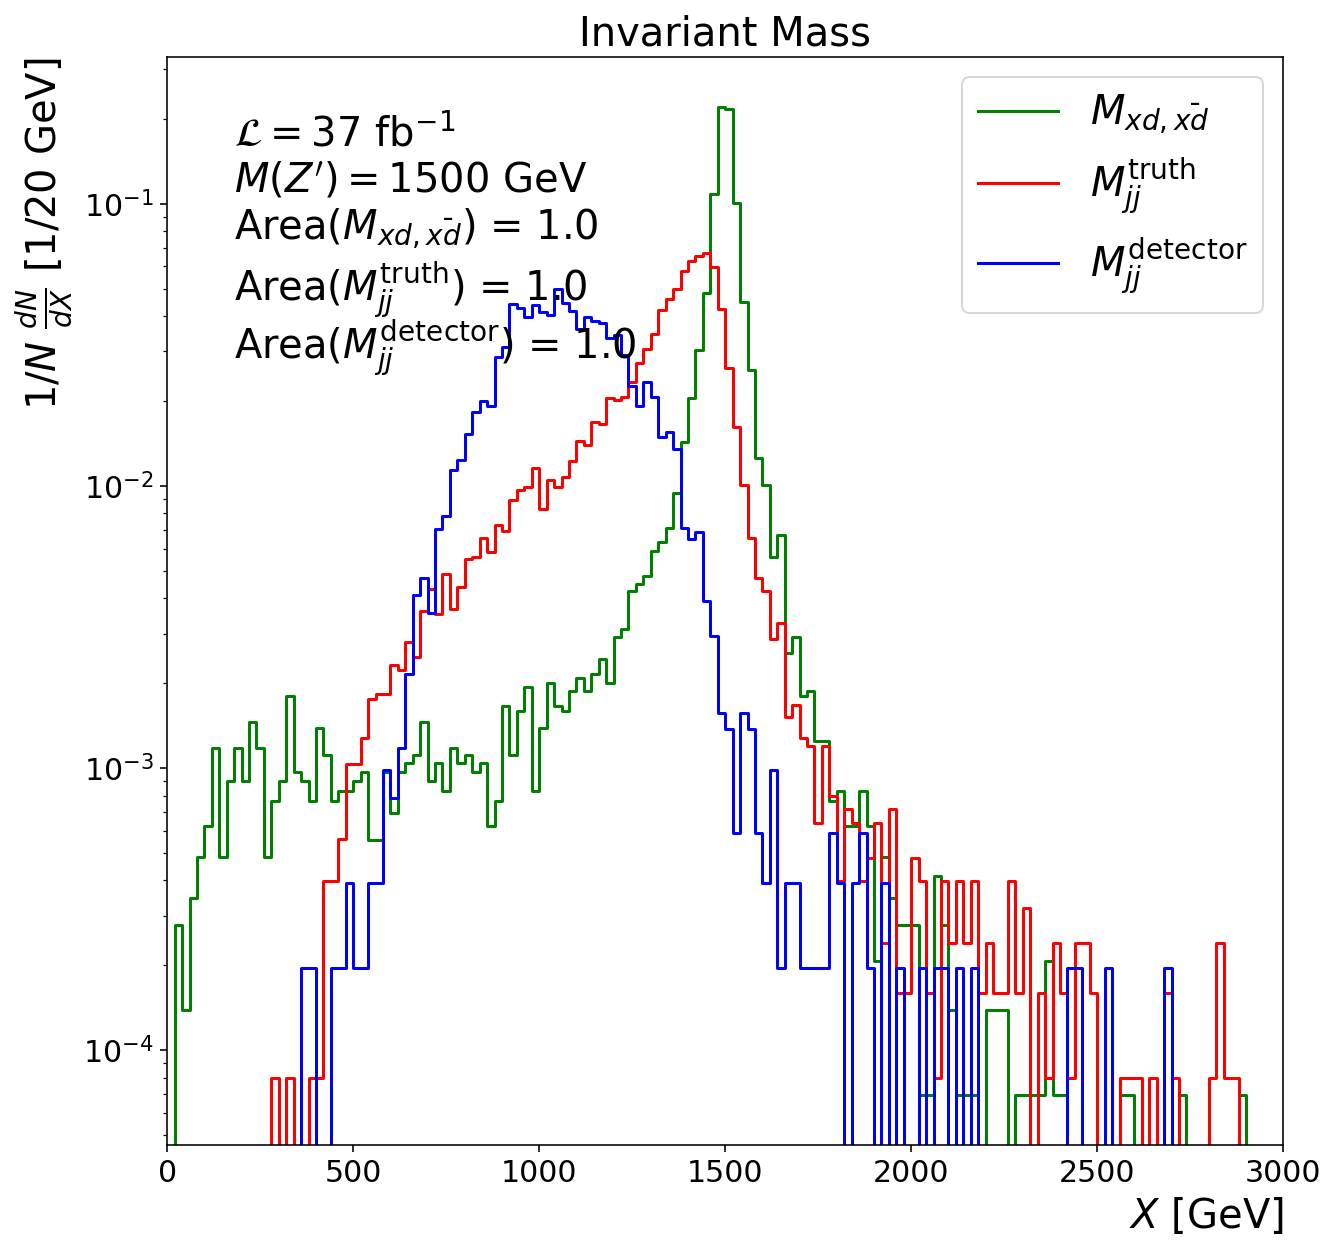

In [63]:
plt.figure(figsize=(10,10))  # plot size
print('Total events = {}'.format(len(m_xdxdbar)))

bin_size = np.linspace(0,5000,251)
hist, bins = np.histogram(m_xdxdbar, bins=bin_size, weights=weight_3_5)
plt.step(bins[:-1], hist/np.sum(hist), where='post', color='green', label='$M_{xd,\\bar{xd}}$')
# plt.step(bins[:-1], hist.astype(np.float32), where='post', color='green', label='$M_{xd,\\bar{xd}}$')

hist_M_JJ, bins_M_JJ = np.histogram(M_JJ, bins=bin_size, weights=weight_3_5[event_sele]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ/np.sum(hist_M_JJ), where='post', color='red', label='$M^\mathrm{truth}_{jj}$')

hist_M_JJ_detec, bins_M_JJ_detec = np.histogram(dijet_mass, bins=bin_size, weights=weight_3_5[survived_list]*37*1000)
plt.step(bins_M_JJ_detec[:-1], hist_M_JJ_detec/np.sum(hist_M_JJ_detec), where='post', color='blue', label='$M^\mathrm{detector}_{jj}$')



plt.text(180, 0.16, '$\mathcal{L} = 37\ \mathrm{fb}^{-1}$', fontsize=20)
plt.text(180, 0.11, '$M(Z^\prime) = 1500$ GeV', fontsize=20)
plt.text(180, 0.075, 'Area($M_{xd,\\bar{xd}}$) = '+str(np.round(np.sum(hist.astype(np.float32)/np.sum(hist)),2)), fontsize=20)
plt.text(180, 0.045, 'Area($M^\mathrm{truth}_{jj}$) = '+str(np.round(np.sum(hist_M_JJ)/np.sum(hist_M_JJ),2)[0]), fontsize=20)
plt.text(180, 0.028, 'Area($M^\mathrm{detector}_{jj}$) = '+str(np.round(np.sum(hist_M_JJ_detec)/np.sum(hist_M_JJ_detec),2)[0]), fontsize=20)



plt.legend(fontsize=20)
plt.yscale('log')
plt.title('Invariant Mass', fontsize=20)
plt.xlabel('$X$ [GeV]', fontsize=20, horizontalalignment='right', x=1)
plt.ylabel('$1/N\ \\frac{dN}{dX}$ [1/20 GeV]', fontsize=20, horizontalalignment='right', y=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,3000)
# plt.ylim(0.001,0.1)
plt.show()

### Example 3: Plot in differential cross section

Total events = 14418


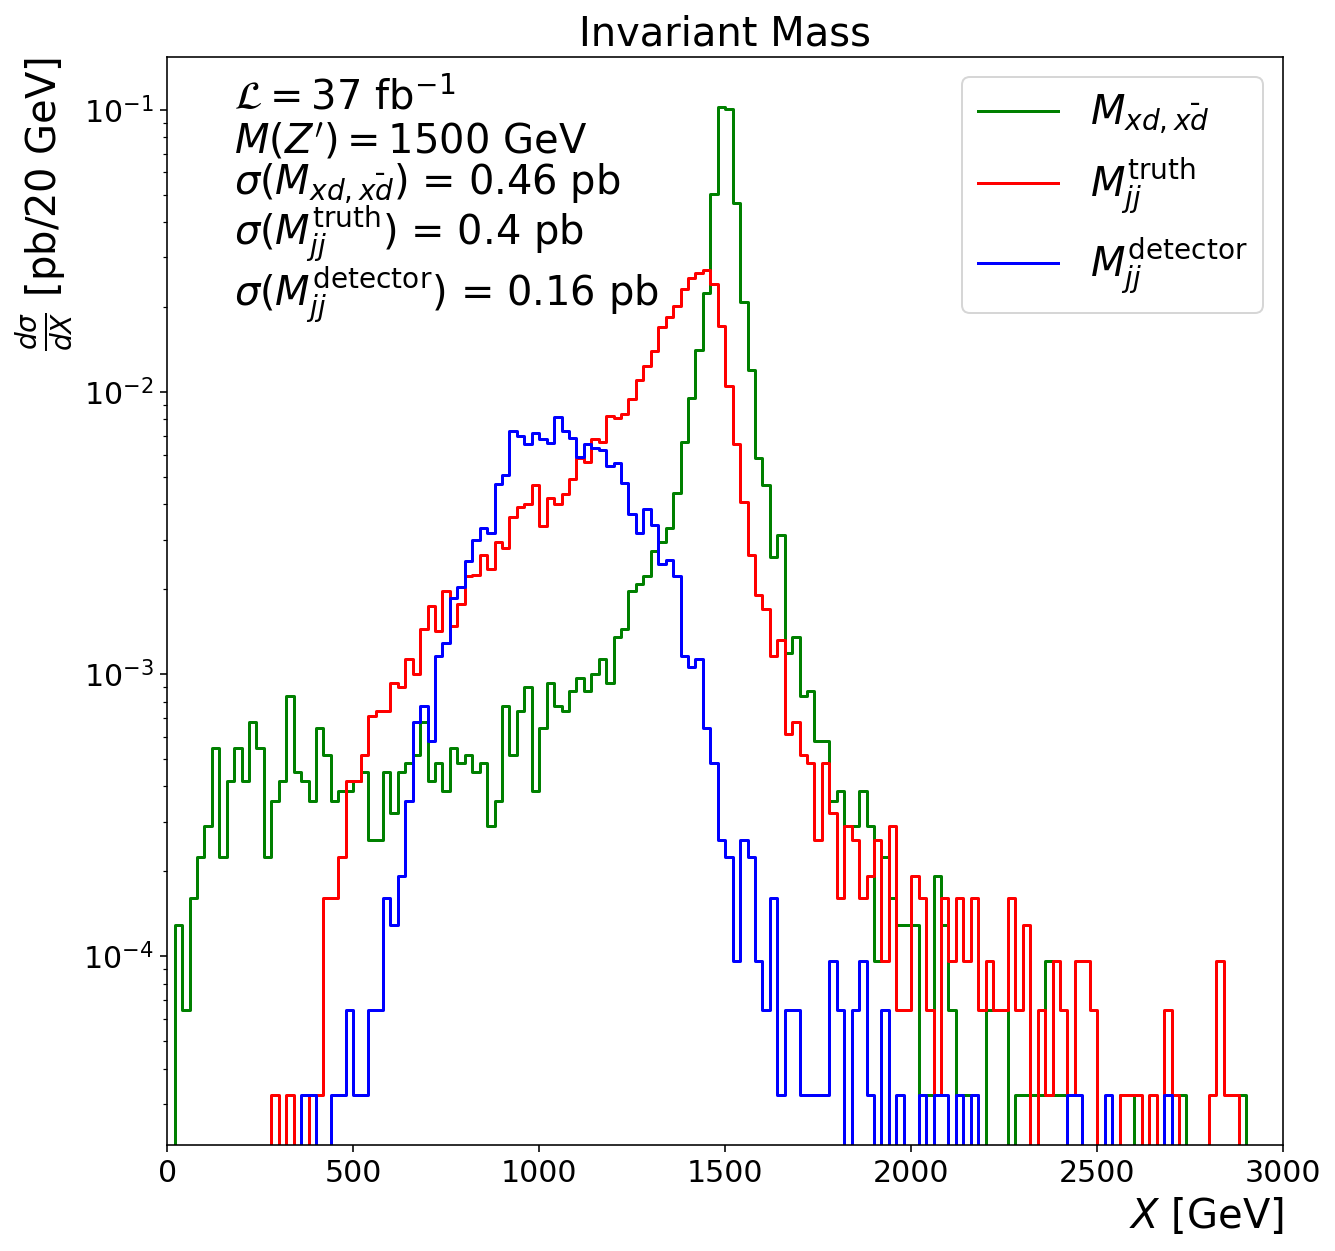

In [70]:
plt.figure(figsize=(10,10))  # plot size
print('Total events = {}'.format(len(m_xdxdbar)))

bin_size = np.linspace(0,5000,251)
hist, bins = np.histogram(m_xdxdbar, bins=bin_size, weights=weight_3_5)
plt.step(bins[:-1], hist, where='post', color='green', label='$M_{xd,\\bar{xd}}$')
# plt.step(bins[:-1], hist.astype(np.float32), where='post', color='green', label='$M_{xd,\\bar{xd}}$')

hist_M_JJ, bins_M_JJ = np.histogram(M_JJ, bins=bin_size, weights=weight_3_5[event_sele])
plt.step(bins_M_JJ[:-1], hist_M_JJ, where='post', color='red', label='$M^\mathrm{truth}_{jj}$')

hist_M_JJ_detec, bins_M_JJ_detec = np.histogram(dijet_mass, bins=bin_size, weights=weight_3_5[survived_list])
plt.step(bins_M_JJ_detec[:-1], hist_M_JJ_detec, where='post', color='blue', label='$M^\mathrm{detector}_{jj}$')



plt.text(180, 0.1, '$\mathcal{L} = 37\ \mathrm{fb}^{-1}$', fontsize=20)
plt.text(180, 0.07, '$M(Z^\prime) = 1500$ GeV', fontsize=20)
plt.text(180, 0.05, '$\sigma(M_{xd,\\bar{xd}})$ = '+str(np.round(np.sum(hist)[0],2))+' pb', fontsize=20)
plt.text(180, 0.033, '$\sigma(M^\mathrm{truth}_{jj})$ = '+str(np.round(np.sum(hist_M_JJ)[0],2))+' pb', fontsize=20)
plt.text(180, 0.02, '$\sigma(M^\mathrm{detector}_{jj})$ = '+str(np.round(np.sum(hist_M_JJ_detec)[0],2))+' pb', fontsize=20)



plt.legend(fontsize=20)
plt.yscale('log')
plt.title('Invariant Mass', fontsize=20)
plt.xlabel('$X$ [GeV]', fontsize=20, horizontalalignment='right', x=1)
plt.ylabel('$\\frac{d\sigma}{dX}$ [pb/20 GeV]', fontsize=20, horizontalalignment='right', y=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,3000)
plt.show()

## Check the $r_\text{inv}$

In [71]:
Lambda_d = [1, 5, 10, 50, 100, 150, 200, 250, 300, 350]
b = (11/3)*2-(2/3)*2
for L in Lambda_d:
    print('Lambda_d = {:^5.1f}  alpha = {:^6.3f}'.format(L, 2*np.pi/(b*np.log(1000/L))))

Lambda_d =  1.0   alpha = 0.152 
Lambda_d =  5.0   alpha = 0.198 
Lambda_d = 10.0   alpha = 0.227 
Lambda_d = 50.0   alpha = 0.350 
Lambda_d = 100.0  alpha = 0.455 
Lambda_d = 150.0  alpha = 0.552 
Lambda_d = 200.0  alpha = 0.651 
Lambda_d = 250.0  alpha = 0.755 
Lambda_d = 300.0  alpha = 0.870 
Lambda_d = 350.0  alpha = 0.997 


In [72]:
print(time.strftime('%m/%d/%Y %a, %H:%M:%S %Z', time.localtime()))
start = datetime.datetime.now()

rinv_4900111, invis_4900111, vis_4900111 = Check_rinv_bRatio(GP_3_5)
print('-'*58)

end = datetime.datetime.now()
print('Time =', end - start)

12/24/2020 Thu, 06:49:45 UTC
There are 14418 events.
There are 6565 Dark Mesons decay into invisible particle.
There are 15494 Dark Mesons decay into visible particle.
r_inv = 0.2976
----------------------------------------------------------
Time = 0:18:39.061806


In [73]:
print(rinv_4900111, invis_4900111, vis_4900111)

0.2976109524457138 6565 15494


In [74]:
print(time.strftime('%m/%d/%Y %a, %H:%M:%S %Z', time.localtime()))
start = datetime.datetime.now()

rinv_4900113, invis_4900113, vis_4900113 = Check_rinv_bRatio(GP_3_5, darkhadron=4900113, dm=53)
print('-'*58)

end = datetime.datetime.now()
print('Time =', end - start)

12/24/2020 Thu, 07:10:42 UTC
There are 14418 events.
There are 19723 Dark Mesons decay into invisible particle.
There are 46009 Dark Mesons decay into visible particle.
r_inv = 0.3001
----------------------------------------------------------
Time = 0:18:42.455393


In [75]:
print(time.strftime('%m/%d/%Y %a, %H:%M:%S %Z', time.localtime()))
start = datetime.datetime.now()

rinv_4900211, invis_4900211, vis_4900211 = Check_rinv_bRatio(GP_3_5, darkhadron=4900211, dm=51)
print('-'*58)

end = datetime.datetime.now()
print('Time =', end - start)

12/24/2020 Thu, 07:37:57 UTC
There are 14418 events.
There are 6595 Dark Mesons decay into invisible particle.
There are 15545 Dark Mesons decay into visible particle.
r_inv = 0.2979
----------------------------------------------------------
Time = 0:19:13.527271


In [76]:
print(time.strftime('%m/%d/%Y %a, %H:%M:%S %Z', time.localtime()))
start = datetime.datetime.now()

rinv_4900213, invis_4900213, vis_4900213 = Check_rinv_bRatio(GP_3_5, darkhadron=4900213, dm=53)
print('-'*58)

end = datetime.datetime.now()
print('Time =', end - start)

12/24/2020 Thu, 07:58:18 UTC
There are 14418 events.
There are 19542 Dark Mesons decay into invisible particle.
There are 45612 Dark Mesons decay into visible particle.
r_inv = 0.2999
----------------------------------------------------------
Time = 0:19:00.279612


#### Note: Total invisible rate

In [77]:
num_invis = invis_4900111+invis_4900113+invis_4900211+invis_4900213
num_vis = vis_4900111+vis_4900113+vis_4900211+vis_4900213
num_invis/(num_invis+num_vis)

0.29942599308907103